In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.makedirs("outputs/plots", exist_ok=True)

#laoding datasets
mat = pd.read_csv("C:\\Users\\samee\\Downloads\\student\\student-mat.csv", sep=";")
por = pd.read_csv("C:\\Users\\samee\\Downloads\\student\\student-por.csv", sep=";")
print("student mat shape:", mat.shape)
print(mat.head(10))
print("student por shape:", por.shape)
print(por.head(10))

#merging datasets
merge_keys = [
    "school", "sex", "age", "address", "famsize", "Pstatus",
    "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"
]
merged = pd.merge(mat, por, on=merge_keys, suffixes=(".mat", ".por"))
print("Overlapping students count:", merged.shape[0])
print("Sample overlapping merged row before cleanup:\n", merged.iloc[0:2])

#taking G1 G2 G3 as average for overlapping
to_avg = ["G1", "G2", "G3"]
fixed = merged.copy()
for col in to_avg:
    fixed[col] = fixed[[f"{col}.mat", f"{col}.por"]].mean(axis=1).round().astype(int)

for col in merged.columns:
    if col.endswith(".mat"):
        base = col[:-4]
        if base in to_avg:
            continue
        fixed[base] = fixed[col]
    elif col.endswith(".por"):
        base = col[:-4]
        if base in to_avg:
            continue
        if base not in fixed.columns:
            fixed[base] = fixed[col]

drop_cols = [c for c in fixed.columns if c.endswith(".mat") or c.endswith(".por")]
fixed = fixed.drop(columns=drop_cols)
print("Cleaned merged overlapping students (grades averaged). Sample:\n", fixed.head(2))

mat_only = mat.merge(fixed[merge_keys], on=merge_keys, how="left", indicator=True)
mat_only = mat_only[mat_only["_merge"] == "left_only"].drop(columns=["_merge"])
por_only = por.merge(fixed[merge_keys], on=merge_keys, how="left", indicator=True)
por_only = por_only[por_only["_merge"] == "left_only"].drop(columns=["_merge"])

#Combine dataset
full_df = pd.concat([fixed, mat_only, por_only], axis=0).reset_index(drop=True)
print("Combined df shape:", full_df.shape)
print("Combined data sample:", full_df.head(10))
print("Value counts of G3 (final grade):\n", full_df["G3"].value_counts().sort_index())

# binary mapping
binary_map = {"yes": 1, "no": 0, "F": 0, "M": 1, "U": 1, "R": 0, "LE3": 0, "GT3": 1, "T": 1, "A": 0}
full_df["sex"] = full_df["sex"].map(binary_map)
full_df["address"] = full_df["address"].map(binary_map)
full_df["famsize"] = full_df["famsize"].map(binary_map)
full_df["Pstatus"] = full_df["Pstatus"].map(binary_map)
for col in ["schoolsup", "famsup", "paid", "activities", "higher", "internet", "romantic", "nursery"]:
    full_df[col] = full_df[col].map({"yes": 1, "no": 0})

print("After binary mapping, sample:\n", full_df[["sex", "address", "famsize", "schoolsup", "higher"]].head(3))
print("Checking for missing values after mapping:\n", full_df.isnull().sum()[full_df.isnull().sum() > 0])

# Separate features and target
y = full_df["G3"]
X = full_df.drop(columns=["G3"])
print("Features shape:", X.shape, "Target shape:", y.shape)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore") )])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

student mat shape: (395, 33)
  school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4   at_home   teacher   
1     GP   F   17       U     GT3       T     1     1   at_home     other   
2     GP   F   15       U     LE3       T     1     1   at_home     other   
3     GP   F   15       U     GT3       T     4     2    health  services   
4     GP   F   16       U     GT3       T     3     3     other     other   
5     GP   M   16       U     LE3       T     4     3  services     other   
6     GP   M   16       U     LE3       T     2     2     other     other   
7     GP   F   17       U     GT3       A     4     4     other   teacher   
8     GP   M   15       U     LE3       A     3     2  services     other   
9     GP   M   15       U     GT3       T     3     4     other     other   

   ... famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0  ...      4        3      4     1     1      3   

In [4]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts().sort_index())

#models and 5 fold cross validation
def make_pipeline(model):
    return Pipeline([("preprocessor", preprocessor), ("regressor", model)])

models = {
    "LinearRegression": make_pipeline(LinearRegression()),
    "DecisionTree": make_pipeline(DecisionTreeRegressor(random_state=42)),
    "RandomForest": make_pipeline(RandomForestRegressor(random_state=42))
}

print("\nCross-validation R² (5-fold) for each model:")
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
    print(f"{name}: mean R² = {scores.mean():.4f}, folds = {np.round(scores, 3).tolist()}")


X_train shape: (545, 32) X_test shape: (137, 32)
y_train distribution:
 G3
0     13
2      1
4      7
5      4
6     17
7     14
8     49
9     29
10    93
11    70
12    77
13    41
14    46
15    25
16    36
17    13
18    10
Name: count, dtype: int64

Cross-validation R² (5-fold) for each model:
LinearRegression: mean R² = 0.8252, folds = [0.813, 0.8, 0.88, 0.797, 0.836]
DecisionTree: mean R² = 0.6548, folds = [0.603, 0.697, 0.657, 0.616, 0.7]
RandomForest: mean R² = 0.8268, folds = [0.823, 0.823, 0.87, 0.764, 0.853]


In [5]:
# hyperparameter tuning
dt_grid = GridSearchCV(
    make_pipeline(DecisionTreeRegressor(random_state=42)),
    {
        "regressor__max_depth": [3, 5, 7, None],
        "regressor__min_samples_split": [2, 5, 10]
    },
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=0
)
dt_grid.fit(X_train, y_train)
print("\nBest Decision Tree params:", dt_grid.best_params_)
print("Decision Tree best CV R²:", round(dt_grid.best_score_, 4))

rf_grid = GridSearchCV(
    make_pipeline(RandomForestRegressor(random_state=42)),
    {
        "regressor__n_estimators": [50, 100, 200],
        "regressor__max_depth": [5, 10, None],
        "regressor__min_samples_split": [2, 5]
    },
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=0
)
rf_grid.fit(X_train, y_train)
print("Best Random Forest params:", rf_grid.best_params_)
print("Random Forest best CV R²:", round(rf_grid.best_score_, 4))

# final evaluation on test set
trained = {
    "LinearRegression": models["LinearRegression"].fit(X_train, y_train),
    "DecisionTree": dt_grid.best_estimator_,
    "RandomForest": rf_grid.best_estimator_
}

eval_results = []
for name, model in trained.items():
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    eval_results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})
    print(f"\n{name} test performance:")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

eval_df = pd.DataFrame(eval_results)
print("\nEvaluation summary table:\n", eval_df)

# feature importance from best random forest
def get_feature_names(ct, numeric_cols, categorical_cols):
    num = numeric_cols
    cat_pipe = ct.named_transformers_["cat"]
    ohe = cat_pipe.named_steps["onehot"]
    cat = ohe.get_feature_names_out(categorical_cols).tolist()
    return num + cat

rf_best = trained["RandomForest"]
rf_reg = rf_best.named_steps["regressor"]
feature_names = get_feature_names(preprocessor, numeric_features, categorical_features)
importances = rf_reg.feature_importances_
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)
print("\nTop 10 feature importances:\n", feat_imp.head(10))



Best Decision Tree params: {'regressor__max_depth': 3, 'regressor__min_samples_split': 2}
Decision Tree best CV R²: 0.782
Best Random Forest params: {'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}
Random Forest best CV R²: 0.8296

LinearRegression test performance:
  R²: 0.8871
  MAE: 0.7601
  RMSE: 1.1030

DecisionTree test performance:
  R²: 0.8702
  MAE: 0.8330
  RMSE: 1.1829

RandomForest test performance:
  R²: 0.9017
  MAE: 0.7194
  RMSE: 1.0290

Evaluation summary table:
               Model        R2       MAE      RMSE
0  LinearRegression  0.887102  0.760073  1.102957
1      DecisionTree  0.870151  0.832977  1.182862
2      RandomForest  0.901736  0.719378  1.028994

Top 10 feature importances:
           feature  importance
0              G2    0.898213
1        absences    0.029725
2              G1    0.009284
3        freetime    0.005475
4          famsup    0.004754
5           goout    0.004260
6  guardian_other    0.003979

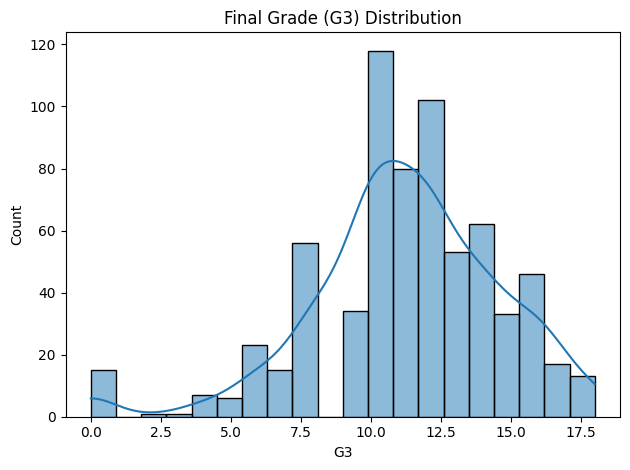

G3 distribution.


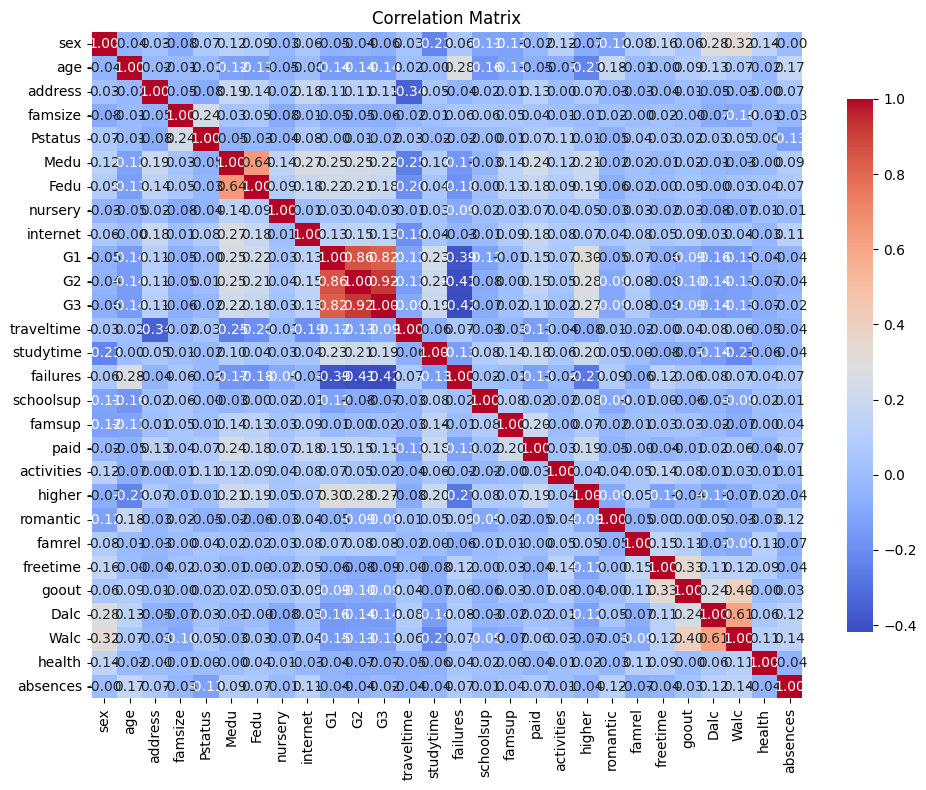

correlation heatmap.


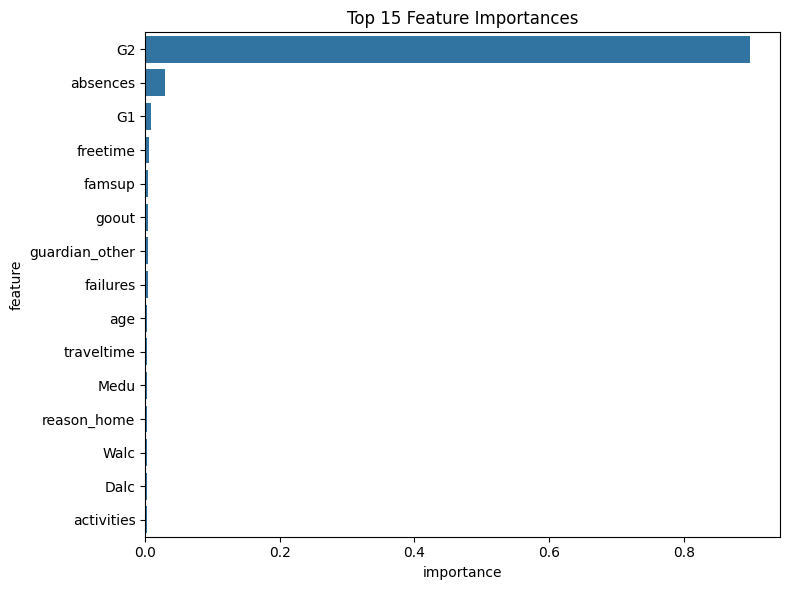

feature importance plot.


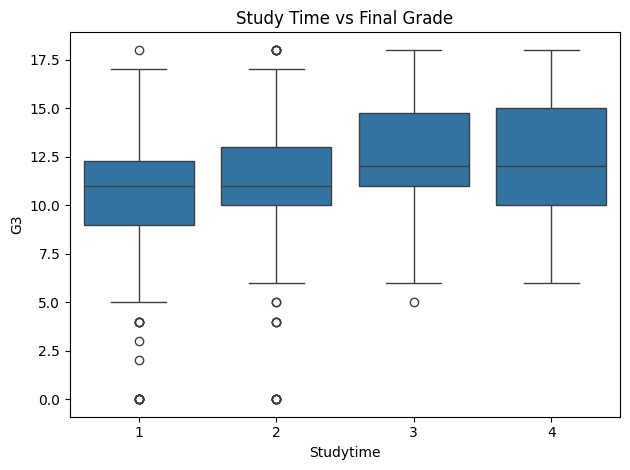

study time vs G3 boxplot.
Saved trained pipelines.


In [6]:
# vusualizations
plt.figure()
sns.histplot(full_df["G3"], bins=20, kde=True)
plt.title("Final Grade (G3) Distribution")
plt.xlabel("G3")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("outputs/plots/g3_distribution.png")
plt.show()
print("G3 distribution.")

plt.figure(figsize=(10, 8))
num_df = full_df.select_dtypes(include=["int64", "float64"])
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig("outputs/plots/correlation_heatmap.png")
plt.show()
print("correlation heatmap.")

plt.figure(figsize=(8, 6))
top15 = feat_imp.head(15)
sns.barplot(data=top15, y="feature", x="importance")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.savefig("outputs/plots/feature_importance_top15.png")
plt.show()
print("feature importance plot.")

plt.figure()
sns.boxplot(x="studytime", y="G3", data=full_df)
plt.title("Study Time vs Final Grade")
plt.xlabel("Studytime")
plt.ylabel("G3")
plt.tight_layout()
plt.savefig("outputs/plots/studytime_vs_g3.png")
plt.show()
print("study time vs G3 boxplot.")

# models saving
joblib.dump(trained["RandomForest"], "outputs/best_random_forest.joblib")
joblib.dump(trained["LinearRegression"], "outputs/linear_regression.joblib")
print("Saved trained pipelines.")

In [7]:

# example prediction
def prepare_example():
    example = {
        "sex": "F",
        "age": 17,
        "address": "U",
        "famsize": "GT3",
        "Pstatus": "T",
        "Medu": 2,
        "Fedu": 2,
        "Mjob": "health",
        "Fjob": "services",
        "reason": "course",
        "guardian": "mother",
        "traveltime": 1,
        "studytime": 2,
        "failures": 0,
        "schoolsup": "no",
        "famsup": "yes",
        "paid": "no",
        "activities": "yes",
        "higher": "yes",
        "internet": "yes",
        "romantic": "no",
        "famrel": 4,
        "freetime": 3,
        "goout": 2,
        "Dalc": 1,
        "Walc": 1,
        "health": 5,
        "absences": 4,
        "nursery": "yes",
        "G1": 14,
        "G2": 15,
        "school": "GP"
    }
    df = pd.DataFrame([example])
    bin_map = {"yes":1,"no":0,"F":0,"M":1,"U":1,"R":0,"LE3":0,"GT3":1,"T":1,"A":0}
    df["sex"] = df["sex"].map(bin_map)
    df["address"] = df["address"].map(bin_map)
    df["famsize"] = df["famsize"].map(bin_map)
    df["Pstatus"] = df["Pstatus"].map(bin_map)
    for col in ["schoolsup","famsup","paid","activities","higher","internet","romantic","nursery"]:
        df[col] = df[col].map({"yes":1,"no":0})
    return df

example_df = prepare_example()
example_pred = trained["RandomForest"].predict(example_df)[0]
print(f"Example student predicted final grade (G3): {example_pred:.2f}")

Example student predicted final grade (G3): 15.90
